In [1]:
# Configuration, import necessary packages

# Prevent long warning message
import warnings
warnings.simplefilter('ignore')

# Import basic data processing packages
import pandas as pd
import numpy as np

# Import machine learning packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Impport visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

/Users/wubing/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Objective

Forecast how popular will a Youtube video be.

# How to measure the popularity

For simlicity, I decide to use number of views as the representative of the popularity, which means I will try to predict the number of views in the notebook

# Loading data

In [2]:
# Since the time limitation, we decide to choose only to use USvideos dataset to approach this problem,
# If I have more time, I will looking into how comtries can affect my prediction

# Remember to change the directory for the data location
USvideos = pd.read_csv('/Users/wubing/Desktop/youtube-new/USvideos.csv')

In [19]:
# Have a sense that what the data looks like
USvideos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,[SHANtell martin],748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"[last week tonight trump presidency, ""last wee...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"[racist superman, ""rudy"", ""mancuso"", ""king"", ""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"[rhett and link, ""gmm"", ""good mythical morning...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"[ryan, ""higa"", ""higatv"", ""nigahiga"", ""i dare y...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [4]:
# Investigage the number of data points and the type of each variable
USvideos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  40949 non-null object
trending_date             40949 non-null object
title                     40949 non-null object
channel_title             40949 non-null object
category_id               40949 non-null int64
publish_time              40949 non-null object
tags                      40949 non-null object
views                     40949 non-null int64
likes                     40949 non-null int64
dislikes                  40949 non-null int64
comment_count             40949 non-null int64
thumbnail_link            40949 non-null object
comments_disabled         40949 non-null bool
ratings_disabled          40949 non-null bool
video_error_or_removed    40949 non-null bool
description               40379 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.2+ MB


In [5]:
# Investigage the distribution of the numerical variabels
USvideos.describe()

,category_id,views,likes,dislikes,comment_count
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


# Feature engineering

After discussing, we decide to get the some information(input) from the user. The following are the list of information
- length of title
- which category is he/she in 
- the numer of tags
- comments disabled or not
- ratings disabled or not

In [6]:
# Get the length of title
title_len = []
for i in range(len(USvideos)):
    title_len.append(len(USvideos['title'][i]))

In [7]:
# Read the json file to get the category information
json = pd.read_json('/Users/wubing/Desktop/youtube-new/US_category_id.json')
json.head()

,kind,etag,items
0,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
1,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
2,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
3,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
4,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."


In [8]:
# Create a category dataframe, I will use this dataframe to find the category for each video
category_id_list = []
category_list = []
for i in range(len(json)):
    category_id_list.append(json['items'][i]['id'])
    category_list.append(json['items'][i]['snippet']['title'])
    
category_df = pd.DataFrame(list(zip(category_id_list, category_list)), 
               columns =['category_id', 'category']) 

In [9]:
# Split the tags volumn  to get a list for each data points
USvideos['tags'] = USvideos['tags'].map(lambda x:x.split('|'))

# Get the number of tags:
num_tags = []
for i in range(len(USvideos)):
    num_tags.append(len(USvideos['tags'][i]))

In [10]:
# Create a new dataframe with the information I need
df = pd.DataFrame(list(zip(title_len, list(USvideos['category_id']), num_tags, list(USvideos['comments_disabled']), 
                           list(USvideos['ratings_disabled']), list(USvideos['views']))), 
               columns =['title_len', 'category_id', 'num_tags', 'comments_disabled', 'ratings_disabled', 'views']) 

In [11]:
df.head()

,title_len,category_id,num_tags,comments_disabled,ratings_disabled,views
0,34,22,1,False,False,748374
1,62,24,4,False,False,2418783
2,53,23,23,False,False,3191434
3,32,24,27,False,False,343168
4,24,24,14,False,False,2095731


# Modeling

In [12]:
# Create X and Y data frame for the prediction model 
X = df[['title_len', 'category_id', 'num_tags', 'comments_disabled', 'ratings_disabled']]
Y = df['views']

In [13]:
# split data in to training and testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [14]:
# Build a random forest regression model with 100 trees 
regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [15]:
# Predict using the test set
y_pred=regr.predict(X_test)

In [16]:
# Get the mean squared error of my prediction
metrics.mean_squared_error(y_test,y_pred) # This can be used for comparing with other models if I have more time

48631544207420.57

In [17]:
# Get the feature importance
feature_imp_regressor = pd.Series(regr.feature_importances_,index=X_train.columns).sort_values(ascending=False)

No handles with labels found to put in legend.


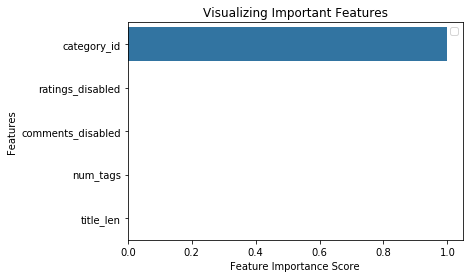

In [18]:
# Visualize the feature importance
sns.barplot(x=feature_imp_regressor, y=feature_imp_regressor.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()